In [ ]:
# импортируем все необходимые библиотеки
import pandas as pd
from sqlalchemy import create_engine, text
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import configparser

In [ ]:
config = configparser.ConfigParser()
# BASE_DIRECT = os.path.dirname(os.path.abspath(__file__))
# PARENT_DIR = os.path.dirname(BASE_DIRECT)
# config_path = os.path.join(PARENT_DIR, "config.ini")
# config = configparser.ConfigParser()
# config.read(config_path)
config.read("config.ini")
db_params = {
    'database': config['database'].get('databname'),
    'user': config['database'].get('user'),
    'password': config['database'].get('password'),
    'host': config['database'].get('host'),
    'port': config['database'].get('port')
}

# Формируем строку подключения с использованием f-строки
engine = create_engine(
    f"postgresql://{db_params['user']}:{db_params['password']}@"
    f"{db_params['host']}:{db_params['port']}/{db_params['database']}"
)
conn = engine.connect()

In [ ]:


try:
    # SQL-запрос
    df = pd.read_sql_query(
    sql=text("SELECT * FROM sale_market WHERE EXTRACT(YEAR FROM purchase_datetime) = 2023"),
    con=engine
)
finally:
    conn.close()

In [ ]:
DF_without0= df[df['quantity']>0]
DF_without0

,client_id,gender,purchase_datetime,purchase_time_as_seconds_from_midnight,product_id,quantity,price_per_item,discount_per_item,total_price
3,952764,M,2023-01-20,64974,27287,8,4887.0,3825.0,8496.0
4,58618,F,2023-02-18,16968,2094,3,6660.0,3394.0,9798.0
5,556533,M,2023-02-18,40369,21600,57,342.0,260.0,4674.0
6,877038,M,2023-02-18,34892,15002,9,2857.0,2140.0,6453.0
7,198202,M,2023-02-20,68735,43730,10,407.0,43.0,3640.0
...,...,...,...,...,...,...,...,...,...
2039874,989807,M,2023-12-28,16573,25633,59,46754.0,46096.0,38822.0
2039875,184945,F,2023-12-28,28050,49490,65,91550.0,26044.0,4257890.0
2039876,791508,F,2023-12-28,73056,38402,73,40677.0,22746.0,1308963.0
2039877,450589,M,2023-12-28,71815,18047,10,5567.0,2192.0,33750.0


In [ ]:
DF_without0['purchase_datetime'] = pd.to_datetime(DF_without0['purchase_datetime'], format='%Y-%m-%d')
df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'], format='%Y-%m-%d')
DF_without0["month"] = DF_without0["purchase_datetime"].dt.to_period("M")
uniq_clients = DF_without0["client_id"].nunique()
print(f"Количество уникальных клиентов за 2023 год: {uniq_clients}")

client_summary = (
    DF_without0.groupby("client_id")
      .agg(
          total_revenue=("total_price", "sum"),
          total_orders=("purchase_datetime", "count"),
          avg_order_value=("total_price", "mean"),
          first_purchase=("purchase_datetime", "min"),
          last_purchase=("purchase_datetime", "max")
      )
).reset_index()
client_summary["diff"] = (
    (client_summary["last_purchase"] - client_summary["first_purchase"]).dt.days
)
client_summary.head()

/tmp/ipython-input-2435036746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_without0['purchase_datetime'] = pd.to_datetime(DF_without0['purchase_datetime'], format='%Y-%m-%d')
/tmp/ipython-input-2435036746.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_without0["month"] = DF_without0["purchase_datetime"].dt.to_period("M")


Количество уникальных клиентов за 2023 год: 864431


,client_id,total_revenue,total_orders,avg_order_value,first_purchase,last_purchase,diff
0,0,1302858.0,1,1302858.0,2023-12-14,2023-12-14,0
1,2,21010.0,1,21010.0,2023-11-05,2023-11-05,0
2,3,1099503.0,5,219900.6,2023-02-14,2023-08-27,194
3,4,16824.0,1,16824.0,2023-03-09,2023-03-09,0
4,5,1011354.0,2,505677.0,2023-01-19,2023-03-04,44


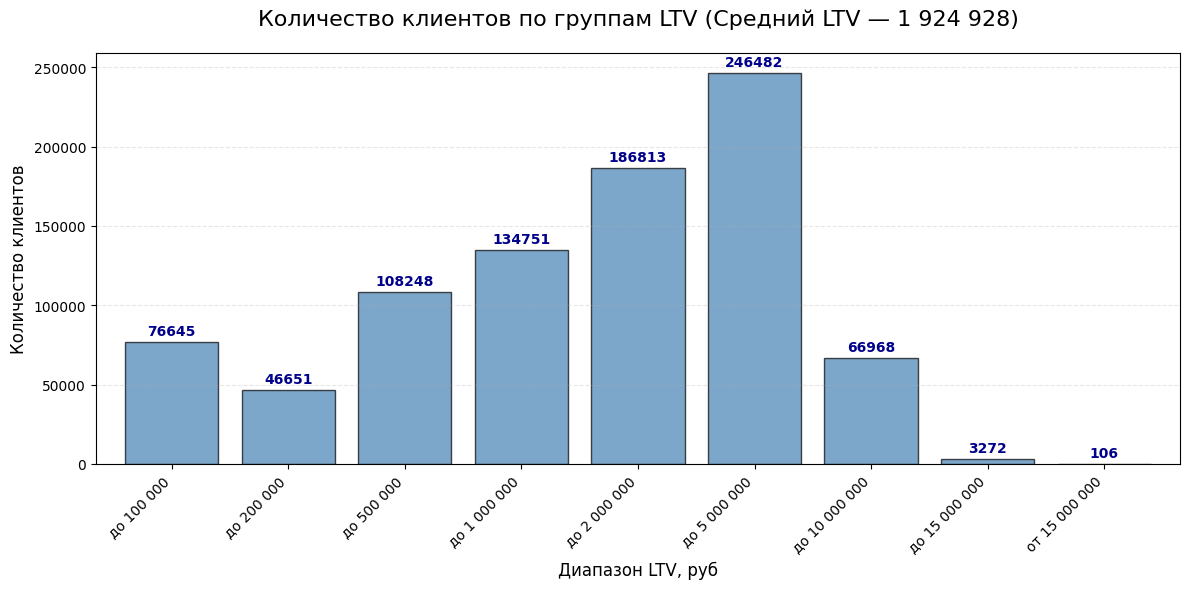

In [ ]:
# 1. Считаем LTV (сумму total_price по client_id)
ltv = df.groupby("client_id")["total_price"].sum().reset_index()


# 2. Приводим к числовому типу и убираем NaN
ltv['total_price'] = pd.to_numeric(ltv['total_price'], errors='coerce')
ltv = ltv.dropna(subset=['total_price'])


# 3. Создаём бины
bins = [
    0,
    100_000,
    200_000,
    500_000,
    1_000_000,
    2_000_000,
    5_000_000,
    10_000_000,
    15_000_000,
    20_000_000

]


# 3. Разметка групп
ltv['LTV_group'], bins = pd.cut(
    ltv['total_price'],
    bins=bins,
    retbins=True,
    include_lowest=True
)

# 4. Считаем количество клиентов в каждой группе
group_counts = ltv['LTV_group'].value_counts().sort_index()

# 5. Строим график
plt.figure(figsize=(12, 6))
mean_ltv = ltv['total_price'].mean()
ax = group_counts.plot(
    kind='bar',
    color='steelblue',
    edgecolor='black',
    alpha=0.7,
    width=0.8
)
title_text = f"Количество клиентов по группам LTV (Средний LTV — {round(mean_ltv,0):,.0f})".replace(",", " ")
# Устанавливаем заголовок
plt.title(title_text, fontsize=16, pad=20)

plt.xlabel("Диапазон LTV, руб", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)


# 6. Подписываем значения над столбцами
for i, (idx, val) in enumerate(group_counts.items()):
    ax.text(
        i,
        val + max(group_counts)*0.01,
        str(val),
        ha='center',
        va='bottom',
        fontsize=10,
        color='darkblue',
        fontweight='bold'
    )

# 7. Настраиваем подписи оси X (диапазоны LTV)
labels = []
for i, bin_interval in enumerate(group_counts.index):
    if i == len(group_counts.index) - 1:

        prev_bin = group_counts.index[i - 1]
        lower_bound = int(prev_bin.right)
        label = f"от {lower_bound:,}".replace(",", " ")
    else:
        # Обычные бины: "до [правая граница]"
        upper_bound = int(bin_interval.right)
        label = f"до {upper_bound:,}".replace(",", " ")
    labels.append(label)

# Применяем метки к оси X
ax.set_xticklabels(
    labels,
    rotation=45,
    ha='right',
    fontsize=10
)
# 8. ВЫЧИСЛЯЕМ СРЕДНИЙ LTV

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
ltvgroup = ltv.groupby('LTV_group').agg({'total_price':'sum'}).reset_index()
ltv['total_price'].sum()
ltvgroup['%'] = ltvgroup['total_price']/ltv['total_price'].sum()
ltvgroup

/tmp/ipython-input-3827277764.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ltvgroup = ltv.groupby('LTV_group').agg({'total_price':'sum'}).reset_index()


,LTV_group,total_price,%
0,"(-0.001, 100000.0]",3.070958e+09,0.001834
1,"(100000.0, 200000.0]",6.923498e+09,0.004135
2,"(200000.0, 500000.0]",3.707165e+10,0.022138
3,"(500000.0, 1000000.0]",9.950700e+10,0.059423
4,"(1000000.0, 2000000.0]",2.730988e+11,0.163086
5,"(2000000.0, 5000000.0]",7.830678e+11,0.467624
6,"(5000000.0, 10000000.0]",4.329642e+11,0.258553
7,"(10000000.0, 15000000.0]",3.713342e+10,0.022175
8,"(15000000.0, 20000000.0]",1.706954e+09,0.001019


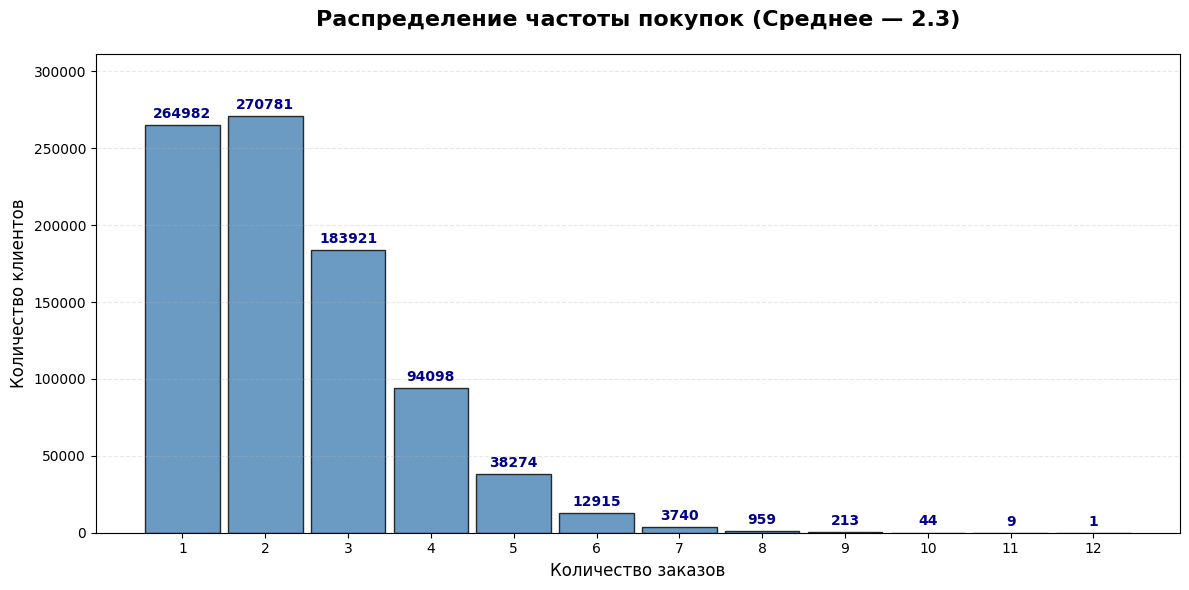

In [ ]:
orders_per_client = df.groupby("client_id")["purchase_datetime"].count().reset_index()
mean_purch = orders_per_client['purchase_datetime'].mean()

# 2. Построение гистограммы
plt.figure(figsize=(12, 6))

n, bins, patches = plt.hist(
    orders_per_client["purchase_datetime"],
    bins=range(1, orders_per_client["purchase_datetime"].max() + 2),
    color="steelblue",
    edgecolor="black",
    alpha=0.8,
    rwidth=0.9
)

# 3. Подписи значений на столбцах
for i, patch in enumerate(patches):
    height = patch.get_height()
    if height > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            height + max(n) * 0.01,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=10,
            color='darkblue',
            fontweight='bold'
        )

# 4. Оформление
title_text = f"Распределение частоты покупок (Среднее — {round(mean_purch,1):,.1f})".replace(",", " ")
plt.title(
    title_text,
    fontsize=16,
    pad=20,
    fontweight='bold'
)
plt.xlabel("Количество заказов", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)


# 5. Сетка
plt.grid(axis='y', alpha=0.3, linestyle='--')


# 6. Подписи оси X (целые числа)
plt.xticks(bins[:-1] + 0.5, [int(b) for b in bins[:-1]], fontsize=10)

# 7. Ограничение по Y
plt.ylim(top=max(n) * 1.15)


# 8. Итоговые настройки
plt.tight_layout()
plt.show()

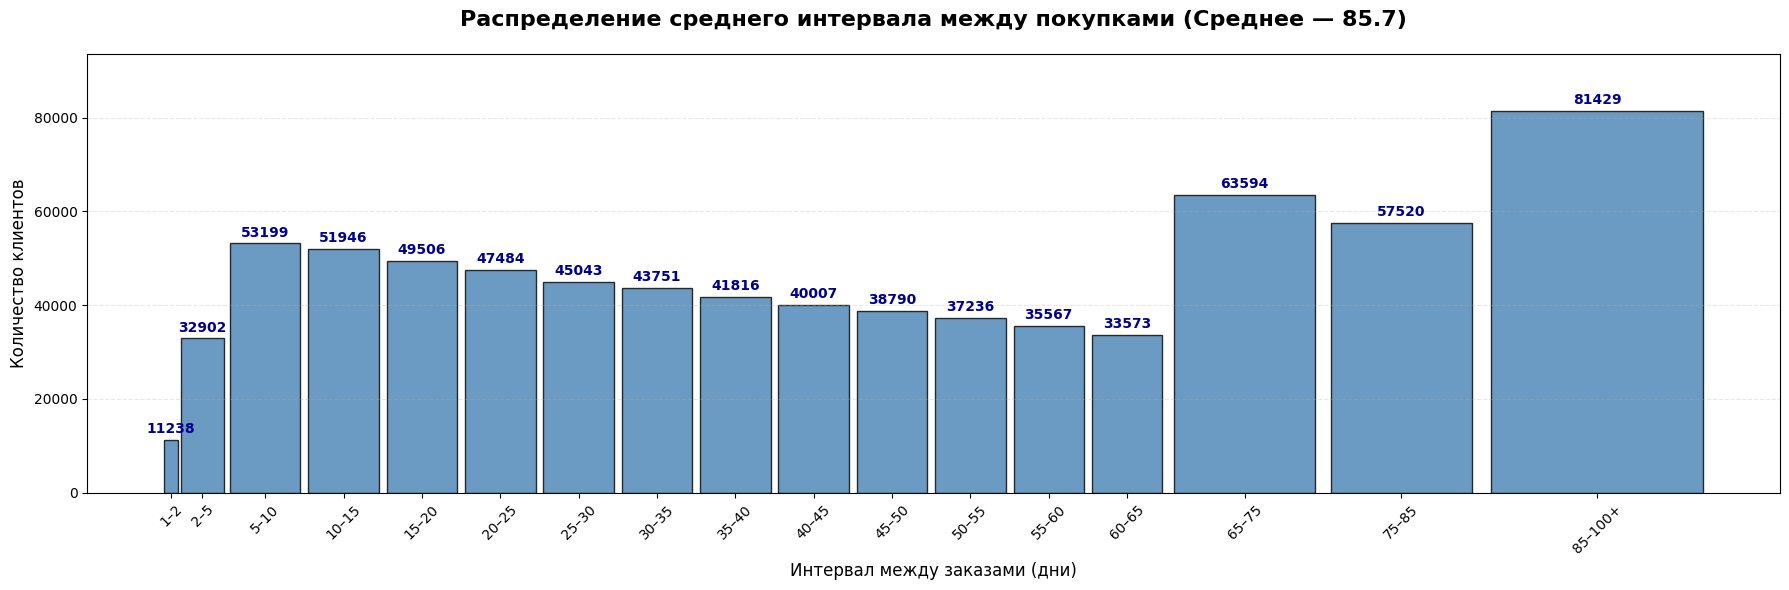

In [ ]:
# 1. Расчёт интервалов между покупками
df_sorted = df.sort_values(["client_id", "purchase_datetime"])
df_sorted["days_between"] = df_sorted.groupby("client_id")["purchase_datetime"].diff().dt.days
intervals = df_sorted["days_between"].dropna()


# 2. Среднее значение
mean_diff = intervals.mean()
title_text = f"Распределение среднего интервала между покупками (Среднее — {mean_diff:,.1f})".replace(",", " ")

# 3. Ваши бины (неравномерные)
bins = [1,2, 5, 10, 15, 20, 25, 30,35, 40, 45, 50, 55, 60,65,75,85,100]


# 4. Построение гистограммы
plt.figure(figsize=(18, 6))


n, bin_edges, patches = plt.hist(
    intervals,
    bins=bins,
    color="steelblue",
    edgecolor="black",
    alpha=0.8,
    rwidth=0.9
)

# 5. Подписи значений на столбцах
for i, patch in enumerate(patches):
    height = patch.get_height()
    if height > 0:
        plt.text(
            patch.get_x() + patch.get_width() / 2,
            height + max(n) * 0.01,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=10,
            color='darkblue',
            fontweight='bold'
        )

# 6. Формирование подписей оси X: диапазоны бинов
labels = []
for i in range(len(bins) - 1):
    left = int(bins[i])
    right = int(bins[i + 1])
    if i == len(bins) - 2:
        labels.append(f"{left}–{right}+")
    else:
        labels.append(f"{left}–{right}")


# 7. Установка подписей на оси X (центрирование по середине бина)
bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.xticks(
    bin_centers,
    labels,
    fontsize=10,
    rotation=45,
    ha='center'  # горизонтальное выравнивание по центру
)

# 8. Оформление заголовка и осей
plt.title(title_text, fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Интервал между заказами (дни)", fontsize=12)
plt.ylabel("Количество клиентов", fontsize=12)

# 9. Сетка
plt.grid(axis='y', alpha=0.3, linestyle='--')


# 10. Ограничение по Y (чтобы подписи не обрезались)
plt.ylim(top=max(n) * 1.15)


# 11. Итоговые настройки
plt.tight_layout()
plt.show()

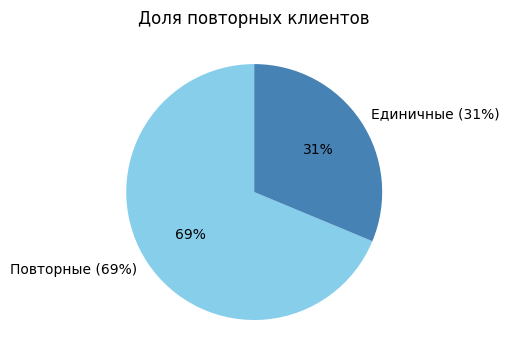

In [ ]:

rep_pur = df[df['quantity'] > 0].groupby('client_id').agg({'quantity': 'count'})
repeat_rate = rep_pur[rep_pur['quantity'] > 1]['quantity'].count() / rep_pur['quantity'].count()


plt.figure(figsize=(5, 5))
plt.pie([repeat_rate, 1 - repeat_rate],
       labels=[f"Повторные ({repeat_rate:.0%})", f"Единичные ({1 - repeat_rate:.0%})"],
       colors=["#87CEEB", "steelblue"],
       autopct="%1.0f%%",
       startangle=90)
plt.title("Доля повторных клиентов")
plt.tight_layout()
plt.show()

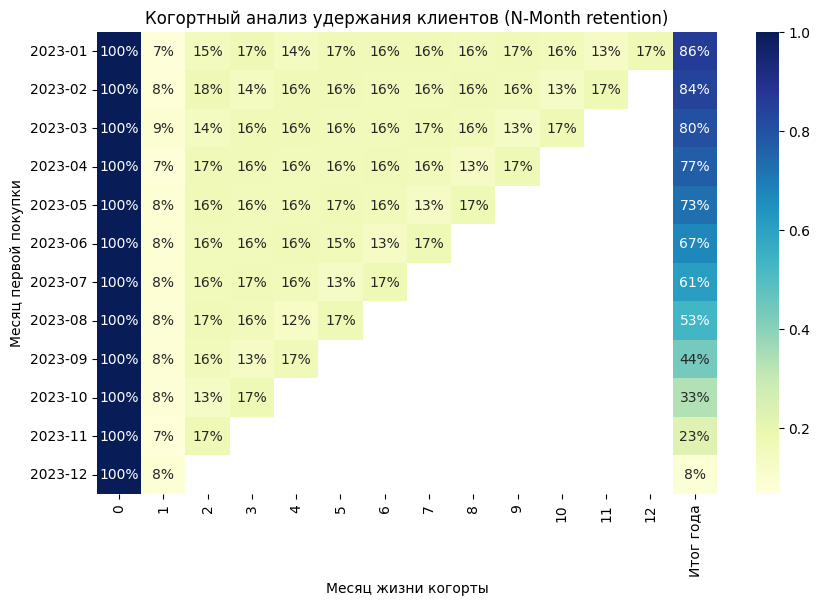

In [ ]:
df["first_purchase_date"] = df.groupby("client_id")["purchase_datetime"].transform("min")
df["cohort_month"] = df["first_purchase_date"].dt.to_period("M")
# df["cohort_index"] = (df["cohort_month"].dt.year - df["first_purchase"].dt.year) * 12 + (df["cohort_month"].dt.month - df["first_purchase"].dt.month) + 1
df["cohort_index"] = (df["purchase_datetime"].dt.year - df["first_purchase_date"].dt.year) * 12 + (df["purchase_datetime"].dt.month - df["first_purchase_date"].dt.month) + 1
df.loc[
    df["purchase_datetime"].dt.date == df["first_purchase_date"].dt.date,
    "cohort_index"
] = 0
cohort_data = df.groupby(["cohort_month", "cohort_index"])["client_id"].nunique().reset_index()
cohort_dataTotal = df[df['cohort_index']>0].groupby(["cohort_month"])["client_id"].nunique().reset_index()
cohort_dataTotal['cohort_index'] = "Итог года"
cohort_data = pd.concat([cohort_data, cohort_dataTotal], ignore_index=True)
cohort_pivot = cohort_data.pivot(index="cohort_month", columns="cohort_index", values="client_id")

cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

plt.figure(figsize=(10,6))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Когортный анализ удержания клиентов (N-Month retention)")
plt.xlabel("Месяц жизни когорты")
plt.ylabel("Месяц первой покупки")
plt.show()

In [ ]:
# 1. Определяем текущую дату (на день позже последней покупки)
current_date = df["purchase_datetime"].max() + pd.Timedelta(days=1)


rfm = (
    df.groupby("client_id")
    .agg(
        Recency=("purchase_datetime", lambda x: (current_date - x.max()).days),
        Frequency=("client_id", "count"),
        Monetary=("total_price", "sum")
    )
)

quantiles = rfm[["Recency", "Frequency", "Monetary"]].quantile([0.33, 0.66]).to_dict()

def get_r_score(recency_vals):
    return pd.cut(
        recency_vals,
        bins=[-1, quantiles["Recency"][0.33], quantiles["Recency"][0.66], float("inf")],
        labels=[3, 2, 1],
        right=True
    ).astype(int)

def get_fm_score(vals, metric):
    return pd.cut(
        vals,
        bins=[-1, quantiles[metric][0.33], quantiles[metric][0.66], float("inf")],
        labels=[1, 2, 3],
        right=True
    ).astype(int)

rfm["R"] = get_r_score(rfm["Recency"])
rfm["F"] = get_fm_score(rfm["Frequency"], "Frequency")
rfm["M"] = get_fm_score(rfm["Monetary"], "Monetary")


rfm["RFM_Segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)
rfm["RFM_Score"] = rfm[["R", "F", "M"]].sum(axis=1)

rfm = rfm.reset_index()
rfm

,client_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,0,18,1,1302858.0,3,1,2,312,6
1,2,57,1,21010.0,3,1,1,311,5
2,3,127,5,1099503.0,2,3,2,232,7
3,4,298,1,16824.0,1,1,1,111,3
4,5,303,2,1011354.0,1,1,2,112,4
...,...,...,...,...,...,...,...,...,...
869932,999994,111,2,5022255.0,2,1,3,213,6
869933,999995,204,1,1634327.0,1,1,2,112,4
869934,999996,63,2,267949.0,3,1,1,311,5
869935,999997,104,2,1173929.0,2,1,2,212,5


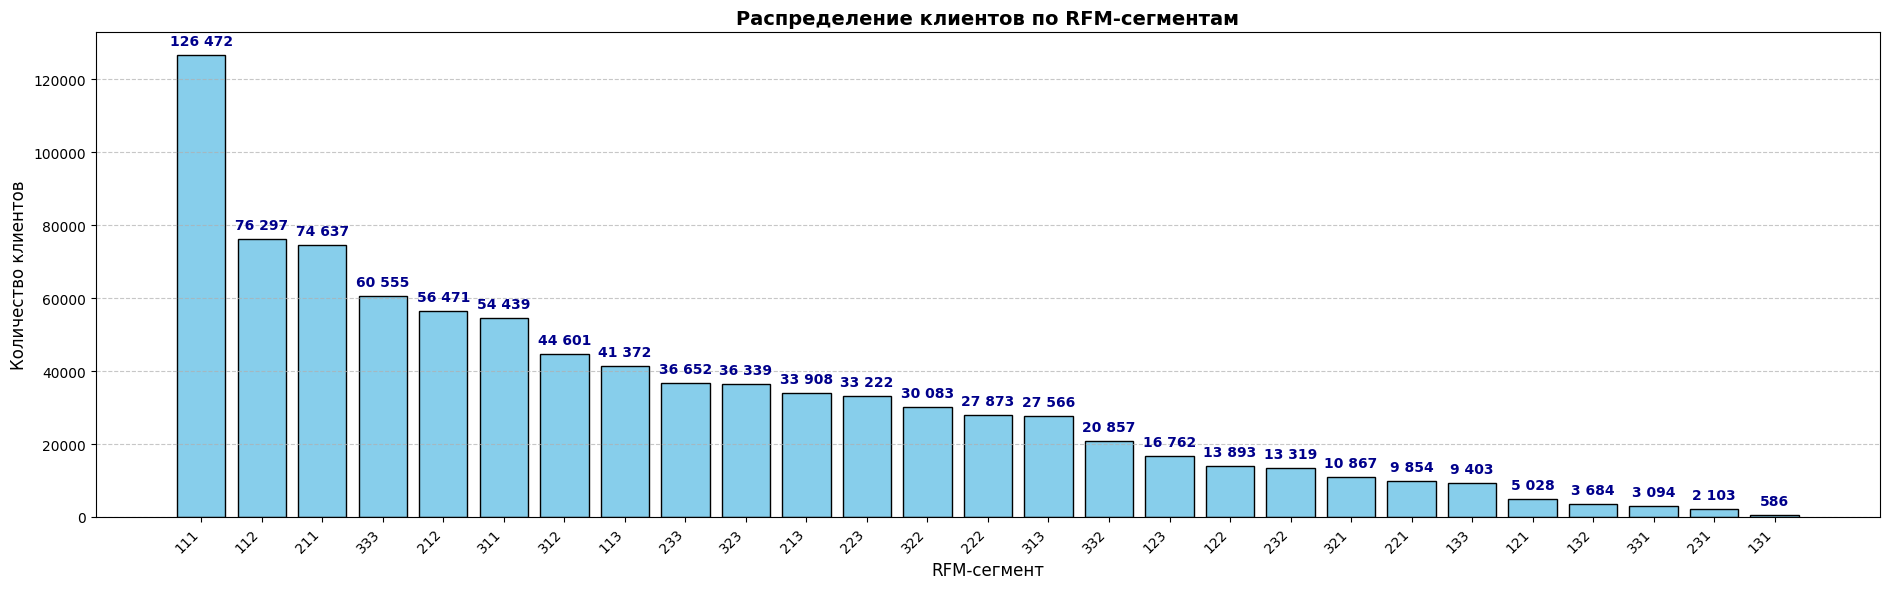

In [ ]:

# Группировка и сортировка
result = (rfm.groupby('RFM_Segment')
           .agg(Колво=('RFM_Segment', 'count'))
           .sort_values('Колво', ascending=False))


# Создаём фигуру и оси
plt.figure(figsize=(19, 6))
bars = plt.bar(result.index, result['Колво'], color='skyblue', edgecolor='black')

# Добавление подписей над столбцами (современный метод)
plt.bar_label(
    bars,
    labels=[f'{x:,}'.replace(',', ' ') for x in result['Колво']],           # Значения для подписей
    label_type='edge',                # Размещение: над верхом столбца
    padding=5,                       # Отступ от верха столбца (в пикселях)
    fontsize=10,
    fontweight='bold',
    color='darkblue'
)

# Подписи осей
plt.xlabel('RFM-сегмент', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.title('Распределение клиентов по RFM-сегментам', fontsize=14, fontweight='bold')

# Поворот подписей по оси X
plt.xticks(rotation=45, ha='right')

# Сетка для удобства чтения
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отступы для корректного отображения подписей
plt.tight_layout()

# Отображаем график
plt.show()
